In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [2]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

/mnt/c/Users/dumon/Documents/Personal/quantum/ibm-qiskitcamp/qiskit-terra/qiskit/pulse/channels/pulse_channels.py:25: DeprecationWarning: Channels have been migrated. Please use `from qiskit.pulse.channels import X` rather than `from qiskit.pulse.channels.pulse_channels import X`.
  DeprecationWarning)


In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
#             ckt.barrier()
            ckt.u2(self.theta,self.phi,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta,self.phi] = to_numbers(parameters)
        self.circuit.data[1][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=10000)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = to_numbers(i[0])
        gradient = [0,0]
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps

            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            result_eps = torch.tensor([exp_value])
            gradient_result = (exp_value - forward_tensor[0][0].item())/eps
            gradient[k] = gradient_result
            
#         print(gradient)
        result = torch.tensor([gradient])
#         print(result)

        return result.float() * grad_output.float()

In [22]:
# x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
x = torch.tensor([[0.0, 0.0]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
y1.backward()
print(x.grad)

tensor([[0., 0.]])


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


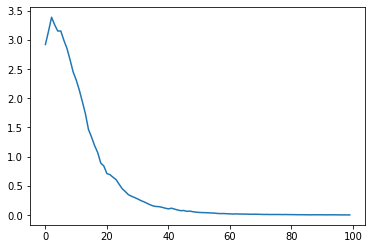

In [23]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x) - target) ** 2, expval

x = torch.tensor([[0.0, np.pi/4]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

batch_size_train = 1
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:100],idx2[0][0:100])) # concatenate their indices
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

Dataset MNIST
    Number of datapoints: 200
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         return F.softmax(x)
#         x = np.pi*F.tanh(x)
#         print(x)
        x = qc(x)
        x = (x+1)/2
        x = torch.cat((x, 1-x), -1)
        return x

In [27]:
network = Net()
# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)

optimizer = optim.Adam(network.parameters(), lr=learning_rate/10)

0.840620522764624
0.7662074770253039
0.7453695544736424
0.7606195308270549
0.7477122633682027
0.7583449403493501
0.7628498672506872
0.8176865612821235
0.7384131376325511
0.7802426262305571


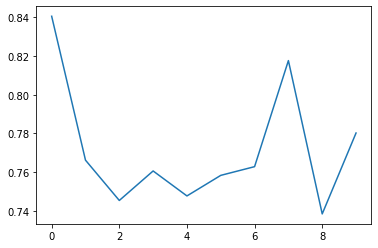

In [28]:
epochs = 10
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
#         print(batch_idx)
        optimizer.zero_grad()
        output = network(data)
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
#         print(output)
#         print(output[0][1].item(), target.item())
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

plt.plot(loss_list)